In [1]:
from datetime import datetime, timezone
import pytz

utc_dt = datetime.now(timezone.utc) # UTC time
dt = utc_dt.astimezone()
tz = pytz.timezone('Europe/Berlin')
berlin_now = datetime.now(tz)
print(f'{berlin_now:%Y-%m-%d %H:%M}')

2022-07-29 15:06


In [2]:
import glob
from os.path import exists
from tqdm import tqdm
import requests

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
structural_annotation = pd.read_parquet('../old_data/structure_annotation.parquet')
sequence_annotation = pd.read_csv('../old_data/Slacustris_eggnog.tsv', sep='\t')

In [4]:
mmseqs = pd.read_csv('../data/cfres_mmseqs_s75_e1.m8', sep="\s+", header=None)
mmseqs.columns = ["query", "target", "seq. id.", "alignment length", "no. mismatches",
                       "no. gap open", "query start", "query end", "target start", "target end",
                       "e value", "bit score"]

mmseqs['gene_id'] = mmseqs['query'].str.split('_').str[:2].apply(lambda x: '_'.join(x))
mmseqs['normalized bit score'] = mmseqs['bit score'] / mmseqs['alignment length']

In [5]:
def best_bit_score(df, sort_by='normalized bit score', tiebreak='alignment length'):
    have_max = df[sort_by] == np.max(df[sort_by])
    max_ali = df[have_max][tiebreak] == np.max(df[have_max][tiebreak])
    return df[have_max][max_ali].index.values[0]

def keep_best(df, groupby='gene_id'):
    df.reset_index(inplace=True)
    idx = df.groupby(groupby).apply(best_bit_score)
    res = df.loc[idx].copy()
    return res

In [6]:
mmseqs_filtered = keep_best(mmseqs)
del mmseqs

In [7]:
hhblits = pd.read_csv('../data/cfres_hhblits_e1.m8', sep="\s+", header=None)
hhblits.columns = ["query", "target", "seq. id.", "alignment length", "no. mismatches",
                       "no. gap open", "query start", "query end", "target start", "target end",
                       "e value", "bit score"]

hhblits['gene_id'] = hhblits['query'].str.split('_').str[:2].apply(lambda x: '_'.join(x))
hhblits['normalized bit score'] = hhblits['bit score'] / hhblits['alignment length']

In [8]:
hhblits_filtered = keep_best(hhblits)
del hhblits

In [15]:
mmseqs_filtered.drop(columns=['index'], inplace=True)
hhblits_filtered.drop(columns=['index'], inplace=True)

In [9]:
sequence_annotation.columns

Index(['evalue', 'score', 'eggNOG_OGs', 'max_annot_lvl', 'COG_category',
       'Description', 'Preferred_name', 'GOs', 'PFAMs', 'gene_id',
       'protein_id'],
      dtype='object')

In [10]:
structural_annotation['normalized bit score'] = structural_annotation['bit score'] / structural_annotation['alignment length']

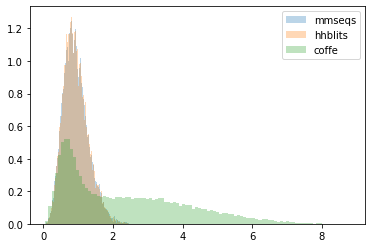

In [11]:
fig, ax = plt.subplots()
ax.hist(mmseqs_filtered['normalized bit score'], bins=100, label='mmseqs', alpha=0.3, density=True);
ax.hist(hhblits_filtered['normalized bit score'], bins=100, label='hhblits', alpha=0.3, density=True);
ax.hist(structural_annotation['normalized bit score'], bins=100, label='coffe', alpha=0.3, density=True);
ax.legend()

In [12]:
unique_up_id = pd.concat([hhblits_filtered['target'].drop_duplicates(),
                          mmseqs_filtered['target'].drop_duplicates()])
unique_up_id.drop_duplicates(inplace=True)

In [13]:
request_size = 500
no_chunks = np.ceil((len(unique_up_id) / request_size) * 3).astype(int)
no_chunks

148

In [14]:
request_size = 500
no_chunks = np.ceil((len(unique_up_id) / request_size) * 3).astype(int)

with open('../data/profile_sequences.fasta', 'w') as result:
    for i in tqdm(range(no_chunks)):
        a = (i * request_size) // 3
        b = ((i+1) * request_size) // 3
        chunk = unique_up_id[a:b]
        bait50 = ['UniRef50_' + c for c in chunk]
        bait90 = ['UniRef90_' + c for c in chunk]
        bait100 = ['UniRef100_' + c for c in chunk]
        expanded_chunk = bait50 + bait90 + bait100
        url = f"https://rest.uniprot.org/uniref/ids?ids={','.join(expanded_chunk)}&format=fasta"
        response = requests.get(url)
        result.write(response.text)

100%|██████████| 148/148 [01:45<00:00,  1.41it/s]


(wait for EggNOG-mapper to annotate the sequences)

In [36]:
file = '/g/arendt/npapadop/data/spongfold_publish/MM_ffr33uy6.emapper.annotations.tsv'
sensitive = pd.read_csv(file, sep='\t', skiprows=4, skipfooter=3, engine='python')

In [43]:
test = sensitive['#query'].str.split('_').str[1]

In [45]:
test.value_counts()

A0A6A6LEY7    3
A0A1X7U3S9    3
A0A3N5U8U0    3
A0A6J0B743    3
A0A482W475    3
             ..
A0A6I8SCD7    1
A0A1A8MN43    1
A0A0C2FDV2    1
A0A2J8INC7    1
A0A0K0D6S2    1
Name: #query, Length: 20360, dtype: int64

In [39]:
sensitive[sensitive['#query'].str.contains('UPI00005B2EF3')].T

Empty DataFrame
Columns: []
Index: [#query, seed_ortholog, evalue, score, eggNOG_OGs, max_annot_lvl, COG_category, Description, Preferred_name, GOs, EC, KEGG_ko, KEGG_Pathway, KEGG_Module, KEGG_Reaction, KEGG_rclass, BRITE, KEGG_TC, CAZy, BiGG_Reaction, PFAMs]

In [28]:
sensitive['uniprot'] = sensitive['#query'].str.split('_').str[1]
sensitive.reset_index(drop=True, inplace=True)
# remove unnecessary columns
dead_weight = ['#query', 'seed_ortholog', 'EC', 'KEGG_ko', 'KEGG_Pathway',
               'KEGG_Module', 'KEGG_Reaction', 'KEGG_rclass', 'BRITE',
               'KEGG_TC', 'CAZy', 'BiGG_Reaction']
sensitive.drop(dead_weight, axis=1, inplace=True)
# convert rest to categorical to save space
to_categorical = ['uniprot', 'eggNOG_OGs', 'max_annot_lvl', 'COG_category',
                  'Description', 'Preferred_name', 'GOs', 'PFAMs']
sensitive[to_categorical] = sensitive[to_categorical].astype("category")
# finally save in parquet format
sensitive.drop_duplicates(inplace=True)
sensitive.to_parquet('../data/uniprot_profiles.parquet')

In [30]:
sensitive.shape

(20360, 10)

In [33]:
unique_up_id

7417224       A0A409VGI9
7453017       A0A6A6LEY7
3711344       A0A1A8QDB6
5432158       A0A1X7UJF6
1658532           S9X2M4
               ...      
144364        A0A2F0BPH8
144949            L1J317
4535244       A0A0K0D6S2
2883206    UPI0003F0A19A
2883636       A0A7S2RZY7
Name: target, Length: 24540, dtype: object

In [35]:
hhblits_filtered[~hhblits_filtered['target'].isin(sensitive['uniprot'])]

query         target  seq. id.  alignment length  \
3537669  c100005_g1_i4_m.41851  UPI000C6D6B72     0.262               138   
3711020  c100012_g4_i1_m.41921     A0A4V1IVK5     0.681               133   
3108519  c100014_g2_i1_m.41927     A0A1D1W000     0.456                59   
7530038  c100023_g1_i1_m.41965  UPI0009E61F51     0.342                90   
5277692  c100036_g1_i4_m.42040     A0A7S3BMQ4     0.523                99   
...                        ...            ...       ...               ...   
8219227   c99972_g1_i2_m.41694  UPI0009E28D88     0.466                63   
6087296   c99980_g3_i1_m.41746  UPI00005B2EF3     0.434                62   
3238079   c99987_g1_i2_m.41772     A0A1X7URN4     0.529               220   
574005    c99993_g2_i1_m.41786  UPI00177B4952     0.663               137   
574028    c99993_g3_i1_m.41790  UPI00106CF215     0.265               133   

         no. mismatches  no. gap open  query start  query end  target start  \
3537669             100             0           13        150             7   
3711020              41             0           32        164            73   
3108519              32             0            4         62           118   
7530038              57             0            3         92          2743   
5277692              46             0           71        169             1   
...                 ...           ...          ...        ...           ...   
8219227              33             0            8         70           392   
6087296              35             0            2         63             7   
3238079              97             0            2        221            37   
574005               41             0            1        137            23   
574028               95             0            3        135            93   

         target end       e value  bit score     gene_id  normalized bit score  
3537669         142  1.464000e-04         53  c100005_g1              0.384058  
3711020         203  3.106000e-49        183  c100012_g4              1.375940  
3108519         176  4.196000e-04         52  c100014_g2              0.881356  
7530038        2829  4.556000e-04         53  c100023_g1              0.588889  
5277692          98  2.166000e-19        100  c100036_g1              1.010101  
...             ...           ...        ...         ...                   ...  
8219227         453  1.130000e-05         57   c99972_g1              0.904762  
6087296          68  4.330000e-05         51   c99980_g3              0.822581  
3238079         243  1.868000e-61        221   c99987_g1              1.004545  
574005          145  1.384000e-49        183   c99993_g2              1.335766  
574028          222  5.938000e-04         52   c99993_g3              0.390977  

[3347 rows x 14 columns]

In [ ]:
mmseqs_filtered

In [ ]:
foldseek_full = pd.read_parquet('../old_data/fs_targets.parquet')

In [ ]:
mmseqs_filtered = mmseqs_filtered.merge(sensitive, on='uniprot', how='left')

In [ ]:

hhblits = hhblits.merge(sensitive, on='uniprot', how='left')